In [2]:
import pandas as pd

# Load ratings data
column_names = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.data', sep='\t', names=column_names)

print(ratings.head())


   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596


In [3]:

# Load movie id and title from item file
movie_columns = ['movie_id', 'title'] + [f'col_{i}' for i in range(22)]
movies = pd.read_csv('/kaggle/input/movielens-100k-dataset/ml-100k/u.item', sep='|', encoding='latin-1', names=movie_columns, usecols=[0,1])


In [4]:
# Merge both
data = pd.merge(ratings, movies, on='movie_id')
print(data.head())

   user_id  movie_id  rating  timestamp                       title
0      196       242       3  881250949                Kolya (1996)
1      186       302       3  891717742    L.A. Confidential (1997)
2       22       377       1  878887116         Heavyweights (1994)
3      244        51       2  880606923  Legends of the Fall (1994)
4      166       346       1  886397596         Jackie Brown (1997)


In [5]:
# Convert to User-Item Matrix
user_movie_matrix = data.pivot_table(index='user_id', columns='title', values='rating')
print(f"Shape of User-Item Matrix: {user_movie_matrix.shape}")
print(f"Number of users: {user_movie_matrix.shape[0]}")
print(f"Number of movies: {user_movie_matrix.shape[1]}")
print(f"Total ratings present: {user_movie_matrix.count().sum()}")


Shape of User-Item Matrix: (943, 1664)
Number of users: 943
Number of movies: 1664
Total ratings present: 99693


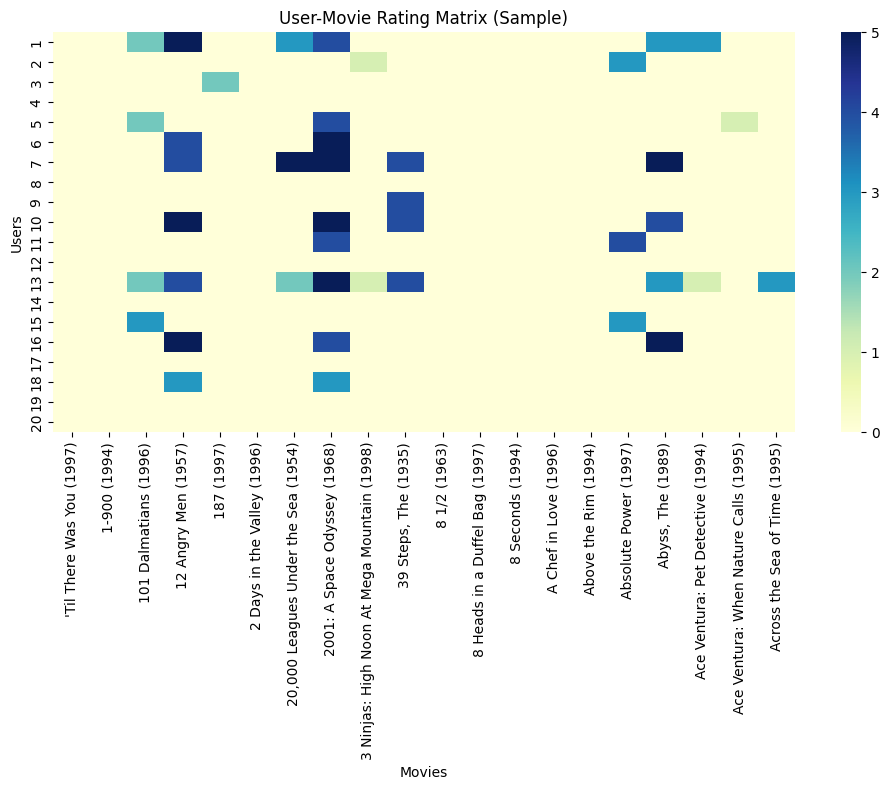

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Sample 20 users and 20 movies for visualization
sample_matrix = user_movie_matrix.iloc[:20, :20]

plt.figure(figsize=(10, 8))
sns.heatmap(sample_matrix.fillna(0), cmap="YlGnBu", annot=False, cbar=True)
plt.title('User-Movie Rating Matrix (Sample)')
plt.xlabel("Movies")
plt.ylabel("Users")
plt.tight_layout()
plt.show()

In [6]:
# Compute User Similarity Matrix
from sklearn.metrics.pairwise import cosine_similarity

# Replace NaN with 0 for similarity
user_movie_filled = user_movie_matrix.fillna(0)

# Cosine similarity between users
user_similarity = cosine_similarity(user_movie_filled)

# Create a DataFrame for easier access
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)


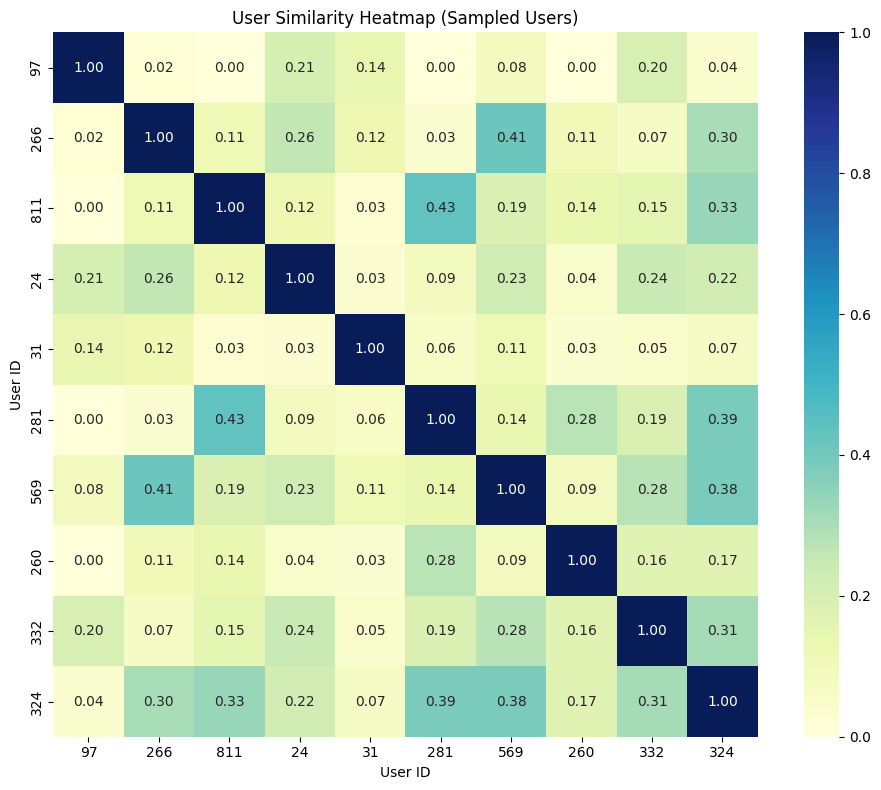

In [38]:
# User Similarity Matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Sample a subset of users for visualization (20 users)
sample_users = user_similarity_df.sample(10, random_state=42)
sample_similarity = user_similarity_df.loc[sample_users.index, sample_users.index]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sample_similarity, cmap="YlGnBu", annot=True, fmt=".2f", square=True)
plt.title("User Similarity Heatmap (Sampled Users)")
plt.xlabel("User ID")
plt.ylabel("User ID")
plt.tight_layout()
plt.show()


In [7]:
# Recommend Movies for a Target User
def recommend_movies(user_id, user_movie_matrix, similarity_df, n_recommendations=5):
    # Get similar users (excluding the user themselves)
    sim_scores = similarity_df[user_id].drop(user_id).sort_values(ascending=False)
    
    # Get the top N similar users
    top_users = sim_scores.head(10).index
    
    # Get movies the target user hasn't watched
    user_ratings = user_movie_matrix.loc[user_id]
    unseen_movies = user_ratings[user_ratings.isna()].index
    
    # Predict ratings by weighted average
    weighted_scores = {}
    for movie in unseen_movies:
        total_sim = 0
        total_weighted_rating = 0
        for other_user in top_users:
            rating = user_movie_matrix.at[other_user, movie]
            if not pd.isna(rating):
                sim = sim_scores[other_user]
                total_sim += sim
                total_weighted_rating += sim * rating
        if total_sim > 0:
            weighted_scores[movie] = total_weighted_rating / total_sim
    
    # Sort by predicted score
    recommended_movies = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    return recommended_movies

recommendations = recommend_movies(user_id=5, user_movie_matrix=user_movie_matrix, similarity_df=user_similarity_df)
print("Top recommendations for user 5:")
for title, score in recommendations:
    print(f"{title}: {score:.2f}")


Top recommendations for user 5:
Circle of Friends (1995): 5.00
Arsenic and Old Lace (1944): 5.00
Fly Away Home (1996): 5.00
Hamlet (1996): 5.00
Jean de Florette (1986): 5.00


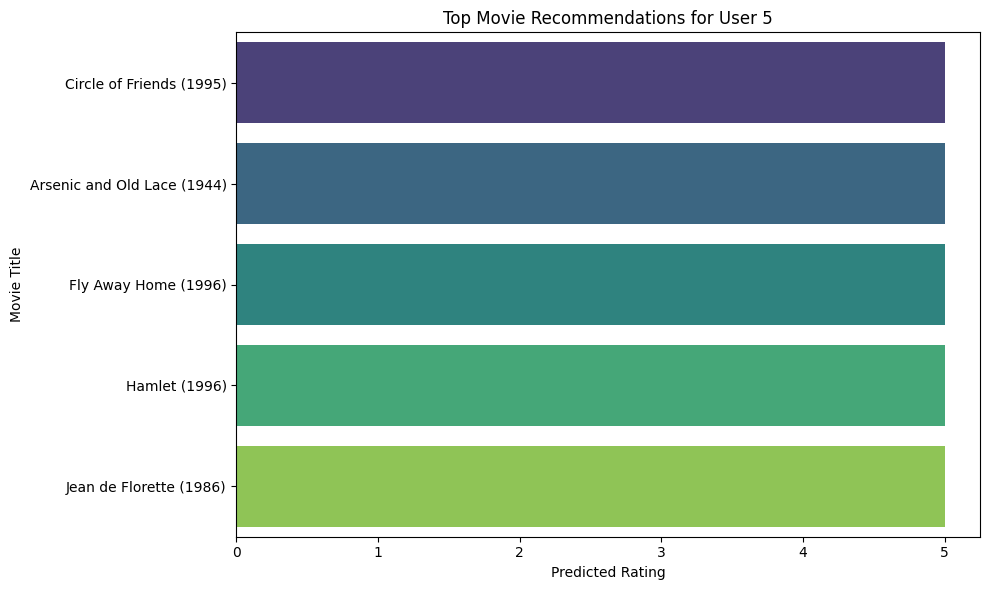

In [14]:
# Top Recommendations for a User (Bar Plot)
user_id = 5
recommendations = recommend_movies(user_id, user_movie_matrix, user_similarity_df, n_recommendations=5)

# Convert to DataFrame for plotting
rec_df = pd.DataFrame(recommendations, columns=['Movie', 'Predicted Rating'])

plt.figure(figsize=(10, 6))
sns.barplot(data=rec_df, x='Predicted Rating', y='Movie', palette='viridis')
plt.title(f"Top Movie Recommendations for User {user_id}")
plt.xlabel("Predicted Rating")
plt.ylabel("Movie Title")
plt.tight_layout()
plt.show()

In [9]:
# Train-Test Split
from sklearn.model_selection import train_test_split

# Create a copy to avoid modifying the original
train_data = []
test_data = []

# For each user, split their ratings
for user_id in data['user_id'].unique():
    user_ratings = data[data['user_id'] == user_id]
    
    if len(user_ratings) >= 5:  # Only if user has enough data
        train, test = train_test_split(user_ratings, test_size=0.4, random_state=42)
        train_data.append(train)
        test_data.append(test)

# Concatenate all user splits
train_df = pd.concat(train_data)
test_df = pd.concat(test_data)

# Build User-Item Matrix from Train Set 
train_matrix = train_df.pivot_table(index='user_id', columns='title', values='rating')
train_matrix_filled = train_matrix.fillna(0) 

# Similarity on train data
user_similarity = cosine_similarity(train_matrix_filled)
user_sim_df = pd.DataFrame(user_similarity, index=train_matrix.index, columns=train_matrix.index)



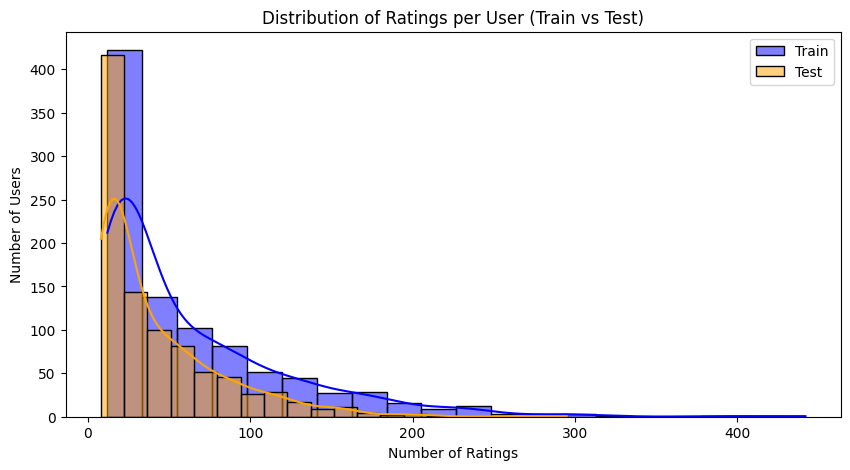

In [16]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Histogram of number of ratings per user (train vs test)
train_counts = train_df['user_id'].value_counts()
test_counts = test_df['user_id'].value_counts()

plt.figure(figsize=(10, 5))
sns.histplot(train_counts, bins=20, kde=True, color='blue', label='Train')
sns.histplot(test_counts, bins=20, kde=True, color='orange', label='Test')
plt.title('Distribution of Ratings per User (Train vs Test)')
plt.xlabel('Number of Ratings')
plt.ylabel('Number of Users')
plt.legend()
plt.show()


In [10]:
# Define Precision@K
def precision_at_k(user_id, train_matrix, test_df, sim_df, k=5):
    if user_id not in train_matrix.index:
        return None
    
    # Get test data for that user
    user_test_data = test_df[test_df['user_id'] == user_id]
    relevant_items = user_test_data[user_test_data['rating'] >= 4]['title'].tolist()

    if not relevant_items:
        return None  # No relevant items to test on

    # Get recommendations
    recs = recommend_movies(user_id, train_matrix, sim_df, n_recommendations=k)
    rec_titles = [title for title, _ in recs]

    # Compute how many of recommended items are relevant
    hits = sum([1 for item in rec_titles if item in relevant_items])
    return hits / k

# Evaluate for Multiple Users
user_ids = test_df['user_id'].unique()
precision_scores = []

for user_id in user_ids:
    score = precision_at_k(user_id, train_matrix, test_df, user_sim_df, k=5)
    if score is not None:
        precision_scores.append(score)

# Average Precision@5
avg_precision = sum(precision_scores) / len(precision_scores)
print(f"Average Precision@5: {avg_precision:.4f}")


Average Precision@5: 0.0740


In [21]:
# Item-Based Collaborative Filtering
from sklearn.metrics.pairwise import cosine_similarity

# Transpose to get items on rows and users on columns
item_movie_matrix = user_movie_matrix.T.fillna(0)
print(f"Shape of User-Item Matrix: {item_movie_matrix.shape}")
print(f"Number of movies: {item_movie_matrix.shape[0]}")
print(f"Number of users: {item_movie_matrix.shape[1]}")

# Compute cosine similarity between movies
item_similarity = cosine_similarity(item_movie_matrix)

# Convert to DataFrame for ease
item_sim_df = pd.DataFrame(item_similarity, index=item_movie_matrix.index, columns=item_movie_matrix.index)


Shape of User-Item Matrix: (1664, 943)
Number of movies: 1664
Number of users: 943


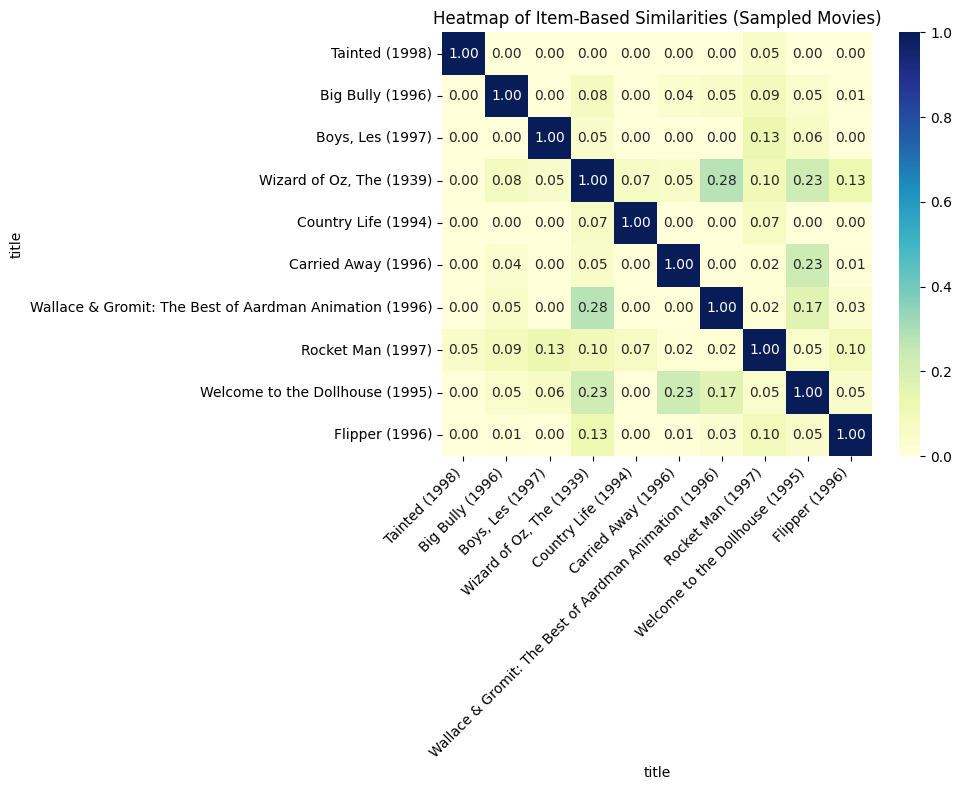

In [28]:
# Heatmap of Item-Item Similarity
# Select a subset of movies for better visualization
sample_movies = item_sim_df.sample(10, random_state=42)  # Or use .head(10)
sample_similarity = item_sim_df.loc[sample_movies.index, sample_movies.index]

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(sample_similarity, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Heatmap of Item-Based Similarities (Sampled Movies)")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [22]:

# Recommend Movies (Item-Based)
def recommend_movies_item_based(user_id, user_movie_matrix, item_sim_df, n_recommendations=5):
    user_ratings = user_movie_matrix.loc[user_id].dropna()

    scores = {}

    for movie, rating in user_ratings.items():
        similar_movies = item_sim_df[movie]
        for sim_movie, similarity in similar_movies.items():
            if sim_movie not in user_ratings:
                scores[sim_movie] = scores.get(sim_movie, 0) + similarity * rating

    # Sort by weighted score
    recommended = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:n_recommendations]
    return recommended

item_based_recs = recommend_movies_item_based(user_id=5, user_movie_matrix=user_movie_matrix, item_sim_df=item_sim_df)
print("Item-based Recommendations for user 5:")
for title, score in item_based_recs:
    print(f"{title}: {score:.2f}")


Item-based Recommendations for user 5:
Terminator, The (1984): 217.49
Jurassic Park (1993): 215.88
Groundhog Day (1993): 211.97
Terminator 2: Judgment Day (1991): 211.29
Pulp Fiction (1994): 207.42


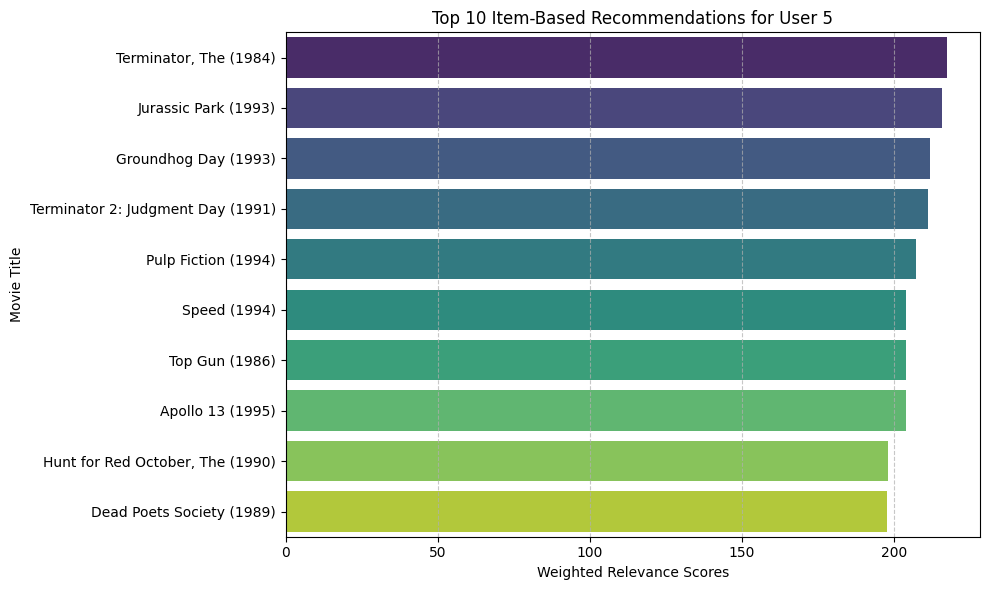

In [27]:
# Visualize top item-based recommendations for a user
import matplotlib.pyplot as plt
import seaborn as sns

# Get recommendations
user_id = 5  # You can change this
item_recommendations = recommend_movies_item_based(user_id, user_movie_matrix, item_sim_df, n_recommendations=10)

# Convert to DataFrame for plotting
rec_df = pd.DataFrame(item_recommendations, columns=['Movie Title', 'Predicted Score'])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Predicted Score', y='Movie Title', data=rec_df, palette='viridis')
plt.title(f'Top 10 Item-Based Recommendations for User {user_id}')
plt.xlabel('Weighted Relevance Scores')
plt.ylabel('Movie Title')
plt.grid(True, axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:

# Evaluate item-based Precision@K
def precision_at_k_item_based(user_id, train_matrix, test_df, item_sim_df, k=5):
    if user_id not in train_matrix.index:
        return None

    relevant_items = test_df[(test_df['user_id'] == user_id) & (test_df['rating'] >= 4)]['title'].tolist()
    if not relevant_items:
        return None

    recs = recommend_movies_item_based(user_id, train_matrix, item_sim_df, n_recommendations=k)
    rec_titles = [title for title, _ in recs]

    hits = sum([1 for item in rec_titles if item in relevant_items])
    return hits / k

# Evaluate for multiple users
user_ids = test_df['user_id'].unique()
precision_scores = [score for user_id in user_ids if (score := precision_at_k_item_based(user_id, train_matrix, test_df, item_sim_df, k=5)) is not None]
avg_precision_item = sum(precision_scores) / len(precision_scores)
print(f"\nAverage Precision@5 (Item-Based): {avg_precision_item:.4f}")



Average Precision@5 (Item-Based): 0.4591


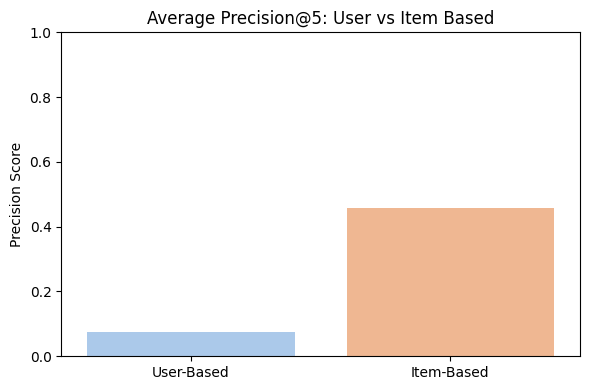

In [33]:
# Compare User-Based vs Item-Based Precision@5
# Dummy values — replace with your actual computed values
precision_user = avg_precision      # From user-based
precision_item = avg_precision_item  # From item-based

# Bar chart comparison
plt.figure(figsize=(6, 4))
sns.barplot(x=['User-Based', 'Item-Based'], y=[precision_user, precision_item], palette='pastel')
plt.title("Average Precision@5: User vs Item Based")
plt.ylabel("Precision Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show() 


In [35]:
# Matrix Factorization with SVD (Singular Value Decomposition)
from sklearn.decomposition import TruncatedSVD

# Fill missing values with 0
matrix_filled = user_movie_matrix.fillna(0)

# Apply SVD
svd = TruncatedSVD(n_components=20, random_state=42)
svd_matrix = svd.fit_transform(matrix_filled)

# Print explained variance
print(f"Explained variance by 20 components: {svd.explained_variance_ratio_.sum():.2f}")

Explained variance by 20 components: 0.41


In [36]:
# Predict full matrix (approximation of original user-movie ratings)
predicted_ratings = svd_matrix @ svd.components_
predicted_df = pd.DataFrame(predicted_ratings, index=user_movie_matrix.index, columns=user_movie_matrix.columns)

In [37]:
# Recommend Movies with SVD Predictions
def recommend_movies_svd(user_id, predicted_df, original_df, n=5):
    user_row = predicted_df.loc[user_id]
    already_rated = original_df.loc[user_id][original_df.loc[user_id].notna()].index
    recommendations = user_row.drop(already_rated).sort_values(ascending=False).head(n)
    return recommendations

top_svd_recs = recommend_movies_svd(user_id=5, predicted_df=predicted_df, original_df=user_movie_matrix)
print("SVD-Based Recommendations for User 5:")
print(top_svd_recs)


SVD-Based Recommendations for User 5:
title
Brazil (1985)                             2.967346
Groundhog Day (1993)                      2.960420
Twelve Monkeys (1995)                     2.779649
Nightmare Before Christmas, The (1993)    2.539540
Raising Arizona (1987)                    2.468197
Name: 5, dtype: float64
